In [ ]:
zip_file_path = '/content/AugmentDataset.zip'  # Replace with your zip file path
destination_folder = '/content/AugmentDataset'  # Folder where you want to unzip the files

# Create the destination folder if it doesn't exist
!mkdir -p $destination_folder

# Unzip the file
!unzip $zip_file_path -d $destination_folder

print(f'File unzipped to {destination_folder}')

In [2]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch.optim as optim
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from IPython.display import Markdown, display
import pandas as pd
import os

In [4]:
dml = torch.device("cuda:0")

transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])         # Convert PIL images to PyTorch tensors
])


In [5]:
def print_metrics(y_pred, y_true):
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(cm)

    # Accuracy
    acc = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {acc:.4f}")

    # Precision
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    print(f"Precision: {precision:.4f}")

    # Recall
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    print(f"Recall: {recall:.4f}")

    # F1
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    print(f"F1 Score: {f1:.4f}\n")

    return [round(acc, 4) ,round(float(precision), 4), round(float(recall), 4), round(float(f1), 4)]

In [14]:
import torch.nn as nn
import torch.nn.functional as F

class EarlyStopping:
    def __init__(self, patience=5, delta=0.0, path='best_model.pth'):
        self.patience = patience
        self.delta = delta
        self.path = path
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(model)
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

    def save_checkpoint(self, model):
        torch.save(model.state_dict(), self.path)

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(224 * 224 * 3, 1024) #wX + b
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 100)

        self.activation = F.relu # max(0, x)


    def forward(self, x):
        x = torch.flatten(x, 1) #flatten image 2d vector into 1d
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = F.sigmoid(self.fc3(x))

        return x

class noBNCNN(nn.Module):
    def __init__(self, n):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8  * n, 11, 3)

        self.conv2 = nn.Conv2d(8  * n, 12 * n, 5, 1, 2)

        self.conv3 = nn.Conv2d(12 * n, 20*n, 3, 1, 1)

        self.conv4 = nn.Conv2d(20*n, 20*n, 3, 1, 1)

        self.conv5 = nn.Conv2d(20*n, 4 * n, 3, 1, 1)

        self.fc1 = nn.Linear(9 * 9 * 4*n, 256)
        self.fc2 = nn.Linear(256, 100)
        #self.fc3 = nn.Linear(256, 100)
        self.pool1 = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool1(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool1(F.relu(self.conv5(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        #x = self.fc3(x)

        return x


class CNN(nn.Module):
    def __init__(self, n):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8  * n, 11, 3)
        self.bn1 = nn.BatchNorm2d(8  * n)
        self.conv2 = nn.Conv2d(8  * n, 12 * n, 5, 1, 2)
        self.bn2 = nn.BatchNorm2d(12 * n)
        self.conv3 = nn.Conv2d(12 * n, 20*n, 3, 1, 1)
        self.bn3 = nn.BatchNorm2d(20*n)
        self.conv4 = nn.Conv2d(20*n, 20*n, 3, 1, 1)
        self.bn4 = nn.BatchNorm2d(20*n)
        self.conv5 = nn.Conv2d(20*n, 4 * n, 3, 1, 1)
        self.bn5 = nn.BatchNorm2d(4*n)
        self.fc1 = nn.Linear(9 * 9 * 4*n, 256)
        self.fc2 = nn.Linear(256, 100)
        #self.fc3 = nn.Linear(256, 100)
        self.pool1 = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool1(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool1(F.relu(self.bn5(self.conv5(x))))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        #x = self.fc3(x)

        return x

class CNNLES(nn.Module):
    def __init__(self, n):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8*n, 11, 3)
        self.bn1 = nn.BatchNorm2d(8*n)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8*n, 4*n, 3)
        self.bn2 = nn.BatchNorm2d(4*n)
        self.fc1 = nn.Linear(17 * 17 * 4*n, 17 * 17)
        self.fc2 = nn.Linear(17 * 17, 100) #20

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool1(F.relu(self.bn2(self.conv2(x))))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x


In [19]:
def testModel(model, error, transform, path):
    model.eval()

    preds = []
    processedLabels = []

    test = datasets.ImageFolder(root= path + 'test', transform=transform)
    testLoader = DataLoader(test, batch_size=1)

    criterion = nn.CrossEntropyLoss()

    torch.cuda.empty_cache()

    testError = 0.0

    for i, data in enumerate(testLoader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # forward + backward + optimize
        with torch.no_grad():
            outputs = model(inputs.to(dml))
        outputs = outputs.squeeze(dim=-1)
        loss = criterion(outputs, labels.to(dml))
        testError += loss.item()

        preds.append(outputs.argmax().item())

        del outputs

        processedLabels.append(labels.item())


    if error:
        return testError/len(testLoader)

    threshold = 0.5
    # binary_list = threshold_to_binary(preds, threshold)
    return print_metrics(preds, processedLabels)


In [16]:
def train(model, lr, batch_size, transformer, num_epochs, path):
    print("Training..")

    dataset = datasets.ImageFolder(root= path + 'train', transform=transformer)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    early_stopping = EarlyStopping(patience=2, delta=0.01)

    trainLossi = []
    testLossi = []
    lossi = []
    indexi = []

    step = 0
    ranEpochs = 0

    for epoch in range(num_epochs):  # loop over the dataset multiple times
        model.train()
        running_loss = 0.0
        cycleLoss = 0.0
        for i, data in enumerate(dataloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs.to(dml))
            outputs = outputs.squeeze()
            loss = criterion(outputs, labels.to(dml))
            loss.backward()
            optimizer.step()

            del inputs
            del labels

            running_loss += loss.item()
            cycleLoss += loss.item()

            step += 1
            if i % 5 == 4:
                lossi.append(cycleLoss / 5)
                indexi.append(step)
                cycleLoss = 0.0
        trainLossi.append(running_loss/len(dataloader))
        valLoss = testModel(model, True, transformer, path)
        testLossi.append(valLoss)
        print("█▄", end = "")
        ranEpochs += 1

        early_stopping(valLoss, model)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

    print('\nFinished Training')
    return [indexi, lossi, trainLossi, testLossi, ranEpochs]

In [9]:
def plotTrainTestError(num_epochs, trainLoss, testLoss):
    plt.figure(figsize=(12, 8))  # Width: 10 inches, Height: 6 inches


    plt.plot(range(num_epochs), trainLoss, label='Train Error', color='blue', linestyle='--')
    plt.plot(range(num_epochs), testLoss, label='Test Error', color='red', linestyle='-')

    # Add labels and legend
    plt.xlabel('Epochs')
    plt.ylabel('Error')
    plt.title('Train vs Test Error')
    plt.legend()  # Display the legend

    # Show the plot
    plt.show()

def plotTrainError(index, loss):
    plt.figure(figsize=(12, 8))

    plt.plot(index, loss)
    plt.title("Loss VS Time Through All Epochs")


## Modeling



### Model Attributes:
- Path: /content/dataset/dataset/
- Type: CNN
    

Training..
█▄█▄█▄█▄█▄
Finished Training


### Results: 

Confusion Matrix:
[[4 0 0 ... 0 0 0]
 [0 3 0 ... 0 0 0]
 [1 0 3 ... 0 0 0]
 ...
 [0 0 1 ... 1 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 3]]
Accuracy: 0.5600
Precision: 0.6233
Recall: 0.5600
F1 Score: 0.5427




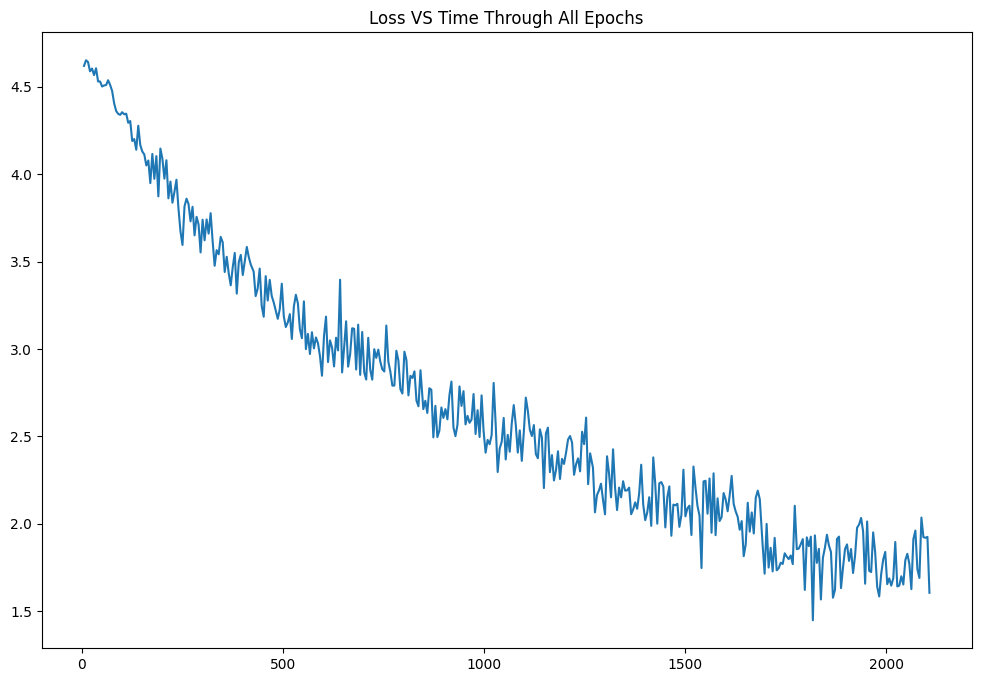

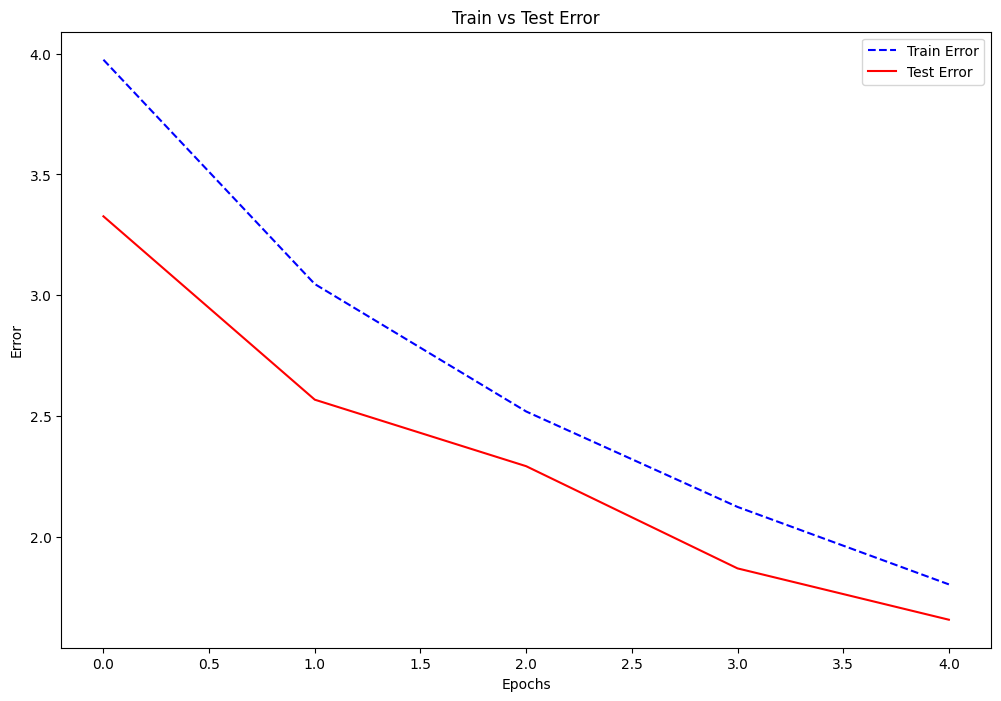


### Model Attributes:
- Path: /content/AugmentDataset/AugmentDataset/
- Type: CNN
    

Training..
█▄█▄█▄█▄█▄
Finished Training


### Results: 

Confusion Matrix:
[[2 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 2 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 3]]
Accuracy: 0.4700
Precision: 0.4939
Recall: 0.4700
F1 Score: 0.4433




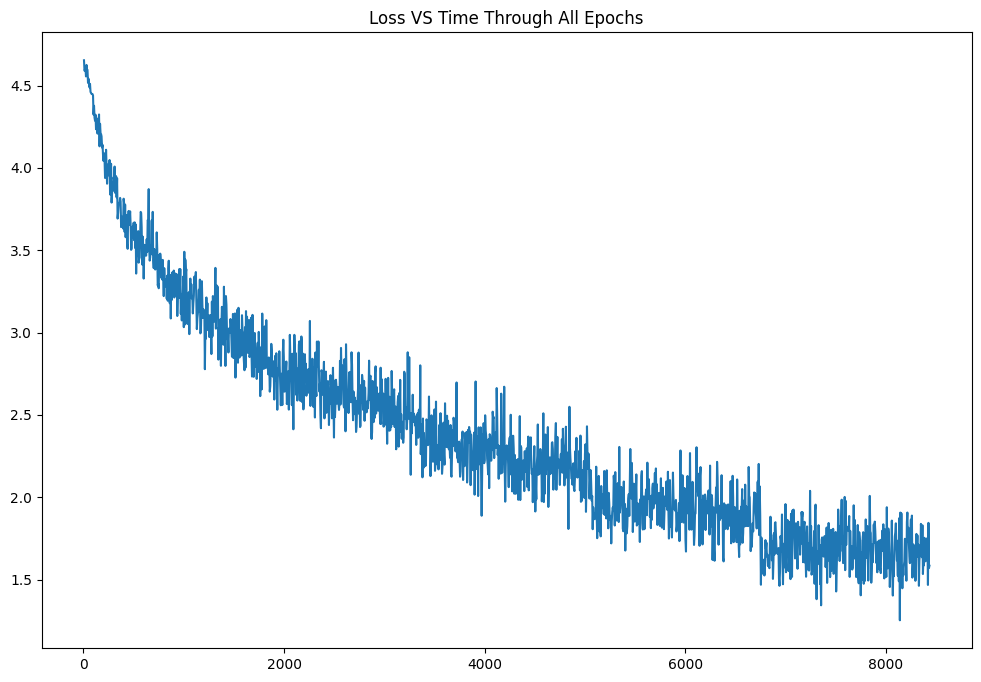

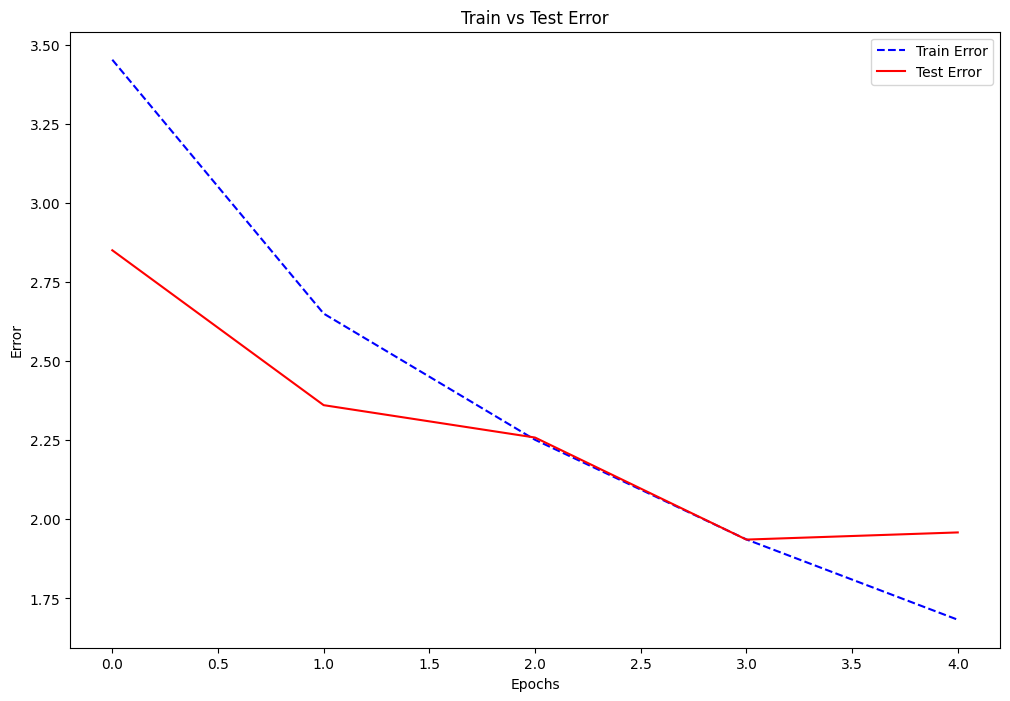


### Model Attributes:
- Path: /content/InvertDataset/InvertDataset/
- Type: CNN
    

Training..
█▄█▄█▄█▄█▄
Finished Training


### Results: 

Confusion Matrix:
[[5 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 2 ... 0 0 0]
 ...
 [0 0 0 ... 5 0 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 0 2]]
Accuracy: 0.5900
Precision: 0.6483
Recall: 0.5900
F1 Score: 0.5753




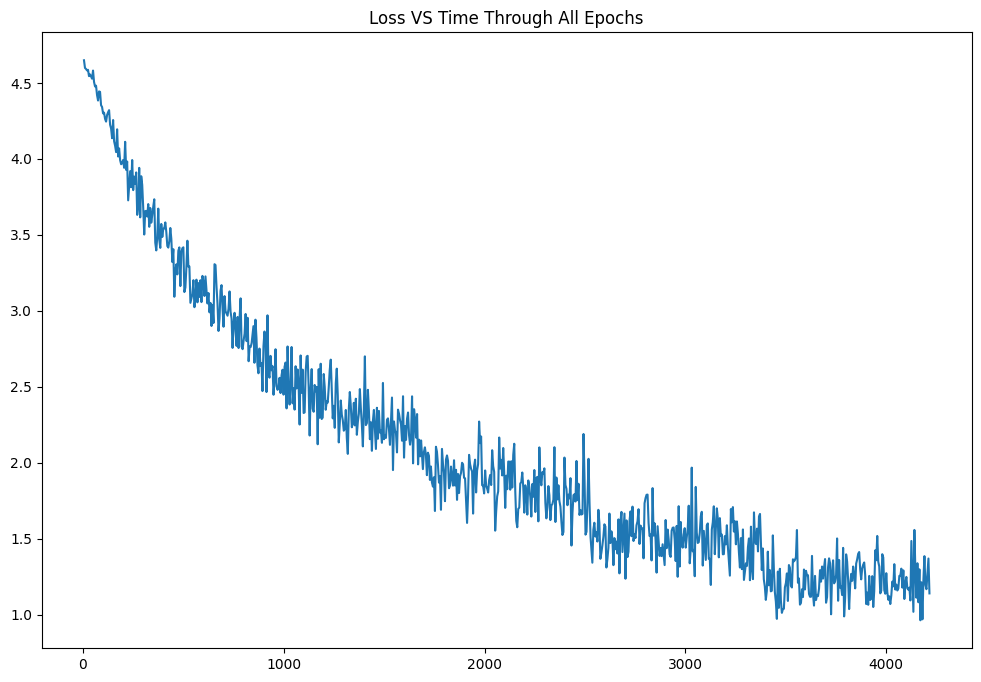

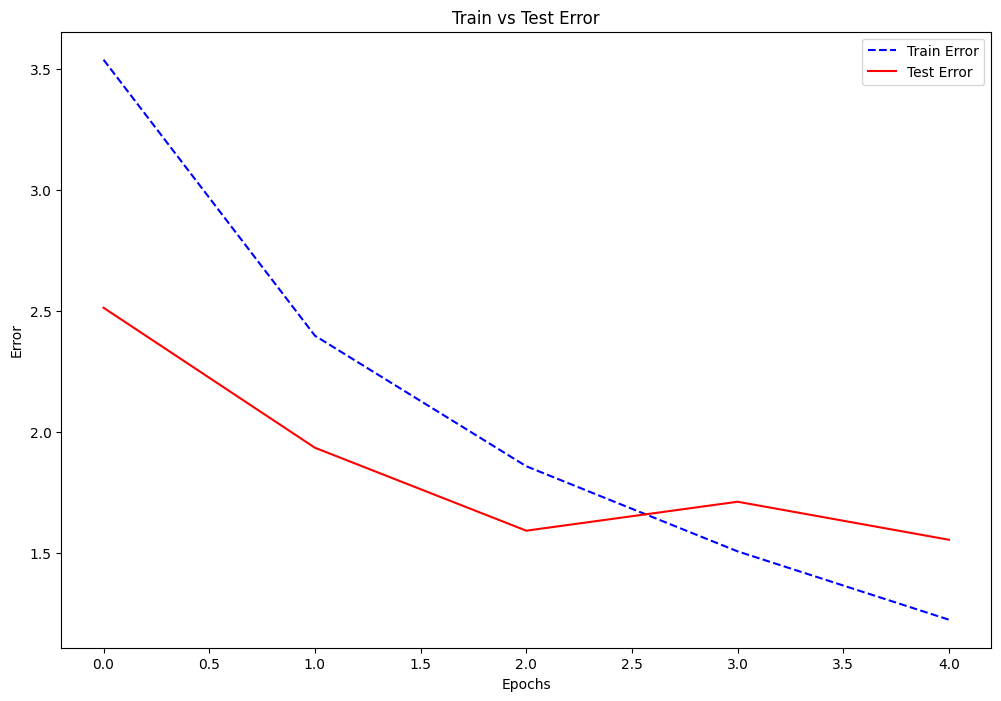

In [22]:
text = """
## Modeling
"""
display(Markdown(text))

inputSize = 224
epoch_num = 5
i = -1
batch_size = 32
lr = 0.002
activation = "Relu"
typee = CNN
n = 5

CNNModels = []

for path in ["/content/dataset/dataset/", "/content/AugmentDataset/AugmentDataset/", "/content/InvertDataset/InvertDataset/"]:
    text = f"""
### Model Attributes:
- Path: {path}
- Type: {typee.__name__}
    """
    display(Markdown(text))

    model = typee(n).to(dml)

    transform = transformer

    metrics = train(model, lr, batch_size, transform, epoch_num, path)

    text = """### Results: """
    display(Markdown(text))

    finalMetrics = testModel(model, False, transform, path)
    plotTrainError(metrics[0], metrics[1])
    print()
    plotTrainTestError(metrics[4], metrics[2], metrics[3])

    i += 1

    modelDetails = [typee.__name__, path]
    modelDetails.extend(finalMetrics)
    CNNModels.append(modelDetails)

In [23]:
pd.DataFrame(CNNModels)

,0,1,2,3,4,5
0,CNN,/content/dataset/dataset/,0.56,0.6233,0.56,0.5427
1,CNN,/content/AugmentDataset/AugmentDataset/,0.47,0.4939,0.47,0.4433
2,CNN,/content/InvertDataset/InvertDataset/,0.59,0.6483,0.59,0.5753
